In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
def find_particle(filename, 
                  init_x=720, 
                  init_y=320, 
                  final_y = 480, 
                  final_x = 880, 
                  filters_kernel=5, 
                  lower_thresh=np.array([0, 0, 0]),
                  upper_thresh=np.array([90, 150, 105]),
                  radius_int=[15, 25],
                  x_int=[20,120],
                  y_int=[20,120]):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    def __increase_contrast__(image):
        '''Increase contrast in image making the particle easier to be detected

        :param img: Original image
        :type path: np.ndarray
        :return enhanced_img: Image with increased contrast
        :rtype enhanced_img: np.ndarray
        '''
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l_channel)
        limg = cv2.merge((cl,a,b))
        enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        return enhanced_img

    contrast = __increase_contrast__(img)
    contrast = __increase_contrast__(contrast)
    cropped = contrast[init_y:final_y, init_x:final_x]
    for i in range(6):
        cropped = cv2.medianBlur(cropped, filters_kernel)
        cropped = cv2.GaussianBlur(cropped, (filters_kernel, filters_kernel), cv2.BORDER_DEFAULT)
    cropped_hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(cropped_hsv, lower_thresh, upper_thresh)
    res = cv2.bitwise_and(cropped, cropped, mask=mask)
    for i in range(5):
        res = cv2.medianBlur(res, filters_kernel)
    contours, _ = cv2.findContours(cv2.Canny(res, 100, 200),  cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        if radius_int[0]<radius<radius_int[1] and x_int[0]<x<x_int[1] and y_int[0]<y<y_int[1]:
            break
    start = (init_x+int(x)-int(radius), init_y+int(y)-int(radius))
    end = (init_x+int(x)+int(radius), init_y+int(y)+int(radius))
    
    sphere = cropped[int(y)-int(radius)+1:int(y)+int(radius),int(x)-int(radius)+1:int(x)+int(radius)]
    def pixel_brightness(pixel):
        assert 3 == len(pixel)
        r, g, b = pixel
        return np.sqrt(0.299 * r ** 2 + 0.587 * g ** 2 + 0.114 * b ** 2)

    brigthness = np.zeros(sphere.shape[:2])
    for i, row in enumerate(sphere):
        for j, pixel in enumerate(row):
            brigthness[i,j] = pixel_brightness(pixel)
                                            
    return contrast, x+init_x, y+init_y, radius, brigthness.mean()

In [3]:
filenames, xs, ys, radiuss, bright_list = [], [], [], [], []
scale = 3
for image in tqdm(os.listdir('images/circle2')):
    if image.split('.')[1]=='jpg':
        contrast, x, y, radius, bright = find_particle('images/circle2/{}'.format(image))
        filenames.append(image)
        xs.append(x)
        ys.append(y)
        radiuss.append(radius)
        bright_list.append(bright)

  0%|                                                                                                               | 0/1461 [00:00<?, ?it/s]/tmp/ipykernel_36723/515721039.py:59: RuntimeWarning: Mean of empty slice.
  return contrast, x+init_x, y+init_y, radius, brigthness.mean()
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [00:39<00:00, 36.87it/s]


In [21]:
df = pd.DataFrame()
df['filename'] = filenames
df['radius'] = radiuss
df['x'] = xs
df['y'] = ys
df['z'] = bright_list
df['index'] = [int(filename.split('.')[0][5:]) for filename in df['filename'].values]
df.to_csv('results/dataframes/raw/circle2.csv', index=None)
df.head()

,filename,radius,x,y,z,index
0,frame583.jpg,2.549610,758.5,320.5,NaN,583
1,frame597.jpg,24.545975,721.5,386.5,NaN,597
2,frame1188.jpg,21.783119,723.5,375.5,NaN,1188
3,frame540.jpg,2.549610,729.5,320.5,NaN,540
4,frame1163.jpg,22.638561,722.5,379.5,NaN,1163


In [6]:
len(df)

1708

In [8]:
outliers = df[(df['x'] < 750)|(df['x'] > 820)|(df['y'] < 370)|(df['y']>430)]
outliers.to_csv('results/dataframes/outliers/circle.csv', index=None)
len(outliers)

30

In [9]:
outliers.sort_values(by=['index']).tail()

,filename,radius,x,y,z,index
1597,frame1179.jpg,18.962132,749.741758,407.118134,109.570307,1179
1391,frame1182.jpg,18.342180,749.918604,408.081398,108.601319,1182
1092,frame1325.jpg,17.270239,749.500000,405.088234,109.080781,1325
1625,frame1345.jpg,16.260357,749.352713,404.089149,107.152314,1345
352,frame1416.jpg,17.137054,749.692623,403.877052,107.384459,1416


In [10]:
df = df[(df['x'] > 750)&(df['x'] < 820)&(df['y'] > 370)&(df['y']<430)]
len(df)
df.to_csv('results/dataframes/filtered/circle.csv', index=None)

In [11]:
df = pd.read_csv('results/dataframes/filtered/circle.csv', index_col=None)

In [12]:
print(df)

           filename     radius           x           y           z  index
0      frame583.jpg  18.928656  759.457596  414.803886  106.032213    583
1      frame597.jpg  20.041954  759.899792  414.382050  104.945867    597
2     frame1188.jpg  18.338215  750.687222  406.036407  108.042501   1188
3     frame1605.jpg  17.925013  753.075359  402.098953  109.776490   1605
4      frame540.jpg  21.508453  759.403168  414.805885  109.100190    540
...             ...        ...         ...         ...         ...    ...
1664   frame565.jpg  19.143484  758.111111  414.111115  105.311325    565
1665  frame1608.jpg  17.846668  752.500000  402.500000  107.648193   1608
1666   frame559.jpg  18.554075  758.500000  413.000000  106.827129    559
1667  frame1191.jpg  17.717009  750.666666  404.666664  110.709238   1191
1668  frame1185.jpg  17.701925  750.824324  407.283783  108.762144   1185

[1669 rows x 6 columns]


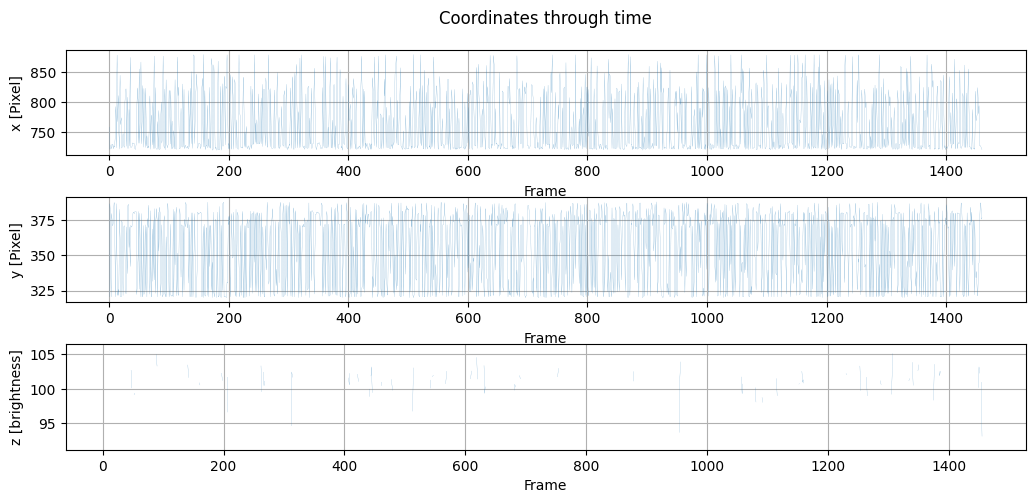

In [6]:
fig, axs = plt.subplots(3)
fig.set_figwidth(12)
fig.set_figheight(5)
fig.suptitle('Coordinates through time')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
axs[0].grid()
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('x [Pixel]')
axs[0].plot(df['x'].values, linewidth=0.1)
  
axs[1].grid()
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('y [Pixel]')
axs[1].plot(df['y'].values, linewidth=0.1)

axs[2].grid()
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('z [brightness]')
axs[2].plot(df['z'].values, linewidth=0.1)

plt.show()

In [18]:
len(os.listdir('images/circle2'))

1461

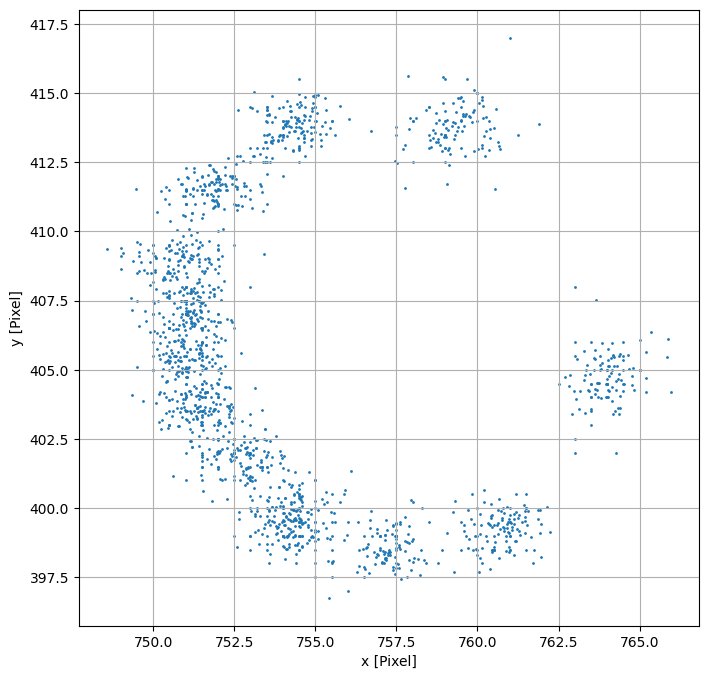

In [20]:
first = pd.read_csv('results/dataframes/raw/circle.csv')
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.scatter(first['x'],first['y'], s=1)
plt.ylabel('y [Pixel]')
plt.xlabel('x [Pixel]')
plt.grid()
#plt.xlim([720, 735])
#plt.ylim([369, 390])
plt.show()

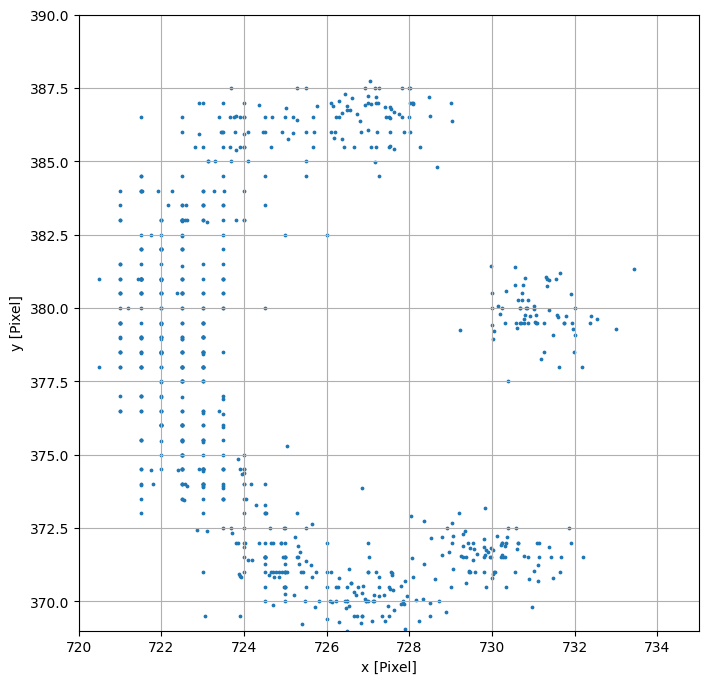

In [24]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.scatter(df['x'], df['y'], s=3)
plt.ylabel('y [Pixel]')
plt.xlabel('x [Pixel]')
plt.grid()
plt.xlim([720, 735])
plt.ylim([369, 390])
plt.show()

In [30]:
max(df['x'].values)

765.9524612426758

In [6]:
xs = df['x'].values
x_filt = [x for x in xs if x < 820]

/tmp/ipykernel_34216/1512026107.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['x'].values, hist=True, kde=False,


<AxesSubplot:>

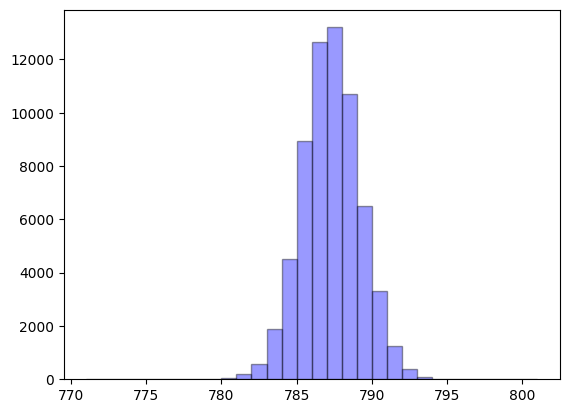

In [7]:
sns.distplot(df['x'].values, hist=True, kde=False, 
             bins=np.arange(771, 802), color = 'blue',
             hist_kws={'edgecolor':'black'})

/tmp/ipykernel_34216/3855389884.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['y'].values, bins=np.arange(388,422), kde=False,


<AxesSubplot:>

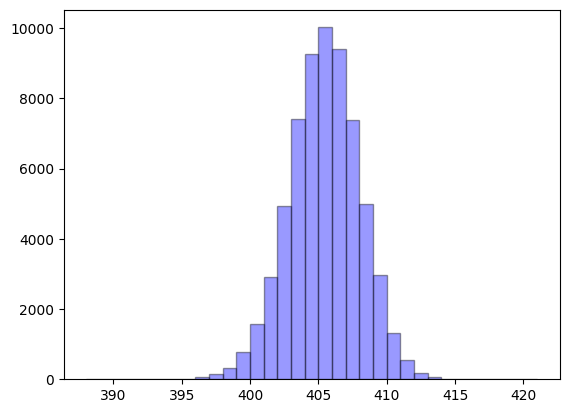

In [8]:
sns.distplot(df['y'].values, bins=np.arange(388,422), kde=False, 
             color = 'blue',
             hist_kws={'edgecolor':'black'})

/tmp/ipykernel_34216/1386330216.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['z'].values, bins=np.arange(91,125), kde=False,


<AxesSubplot:>

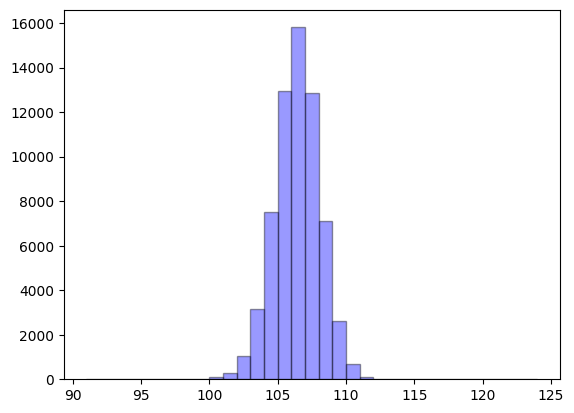

In [14]:
sns.distplot(df['z'].values, bins=np.arange(91,125), kde=False, 
             color = 'blue',
             hist_kws={'edgecolor':'black'})